In [48]:
# Imports and Setup
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import cv2
import os
from collections import defaultdict
import re
import pickle
from pathlib import Path
import git
import pandas as pd

from skimage import img_as_float, exposure
from skimage.filters import gabor_kernel
import scipy.ndimage as ndi
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")
SAVE_FIGS=True
# Visualizing Raw Filters
np.random.seed(0)

# Load pretrained AlexNet
alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.eval()  # set to evaluation mode

# Extract the first convolutional layer filters
first_conv = alexnet.features[0]
filters = first_conv.weight.data.clone().cpu().numpy()  # shape: [out_channels, in_channels, height, width]

print("First layer filters shape:", filters.shape)
#filter groupings
filter_groups = {
    "single edge": [3, 6, 10, 11, 12, 13, 14, 23, 24, 28, 29, 30, 32, 34, 43, 48, 49, 50, 55, 57], #gabor-like / edge detector
    "multi edge": [9, 16, 18, 22, 25, 27, 33, 41, 54, 63], #complex gabor / complex edge detector
    "eye": [21, 31, 37, 39, 45, 46,], # color contrast
    "dual color": [0, 2, 4, 5, 17, 20, 26, 38, 42, 44, 47, 56, 59], # color contrast
    "inside out": [7, 15, 19, 35, 40, 51, 52, 53, 58], # smoothing
    "misc": [1, 8, 36, 60, 61, 62] # misc
}

sum([len(i) for i in filter_groups.values()])

First layer filters shape: (64, 3, 11, 11)


64

In [49]:
def _generate_gabor_kernel_skimage_cached(frequency: float,
                                          wave_number: int,
                                          theta: float,
                                          aspect_ratio: float,
                                          dtype_str: str) -> np.ndarray:
    if frequency <= 0:
        raise ValueError("frequency must be positive (cycles/pixel).")
    
    # choose n_stds explicitly (same value you pass to gabor_kernel; default is 3)
    n_stds = 3
    sigma_x = wave_number / (2.0 * n_stds * frequency)   # NOT 4*frequency
    sigma_y = aspect_ratio * sigma_x
    k_complex = gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma_x, sigma_y=sigma_y, n_stds=n_stds)

    k = np.real(k_complex).astype(np.dtype(dtype_str), copy=False)
    k -= k.mean()
    nrm = np.linalg.norm(k.ravel())
    if nrm > 1e-12:
        k = k / nrm
    return k

def generate_gabor_kernel_skimage(frequency: float,
                                  wave_number: int,
                                  theta: float = 0.0,
                                  aspect_ratio: float = 1.0,
                                  dtype=np.float64) -> np.ndarray:
    """Public wrapper returning a copy to avoid accidental mutation of cached data."""
    arr = _generate_gabor_kernel_skimage_cached(
        float(frequency), int(wave_number), float(theta),
        float(aspect_ratio), np.dtype(dtype).name
    )
    if arr is not None:
        return arr.copy()
    return None

In [50]:
PARAM_CSV = "gabor_new.csv"
param_df = pd.read_csv(os.path.join(ROOT_DIR, "gabor", PARAM_CSV))
# param_df = pd.read_csv(os.path.join(ROOT_DIR, "gabor", "gabor_test.csv"))

orientations = [0, np.pi/6, np.pi/3, np.pi/2, 2*np.pi/3, 5*np.pi/6]

gabor_filters = []
for i in range(len(param_df)):
    fil_orients = []

    for j in range(len(orientations)):
        fil = generate_gabor_kernel_skimage(param_df["frequency"][i], param_df["wave_number"][i], orientations[j], param_df["aspect_ratio"][i])
        if fil is not None:
            fil_orients.append(fil)
    
    gabor_filters.append(fil_orients)

print(gabor_filters[0][0].shape)
print(len(gabor_filters), len(gabor_filters[0]))

(25, 47)
42 6


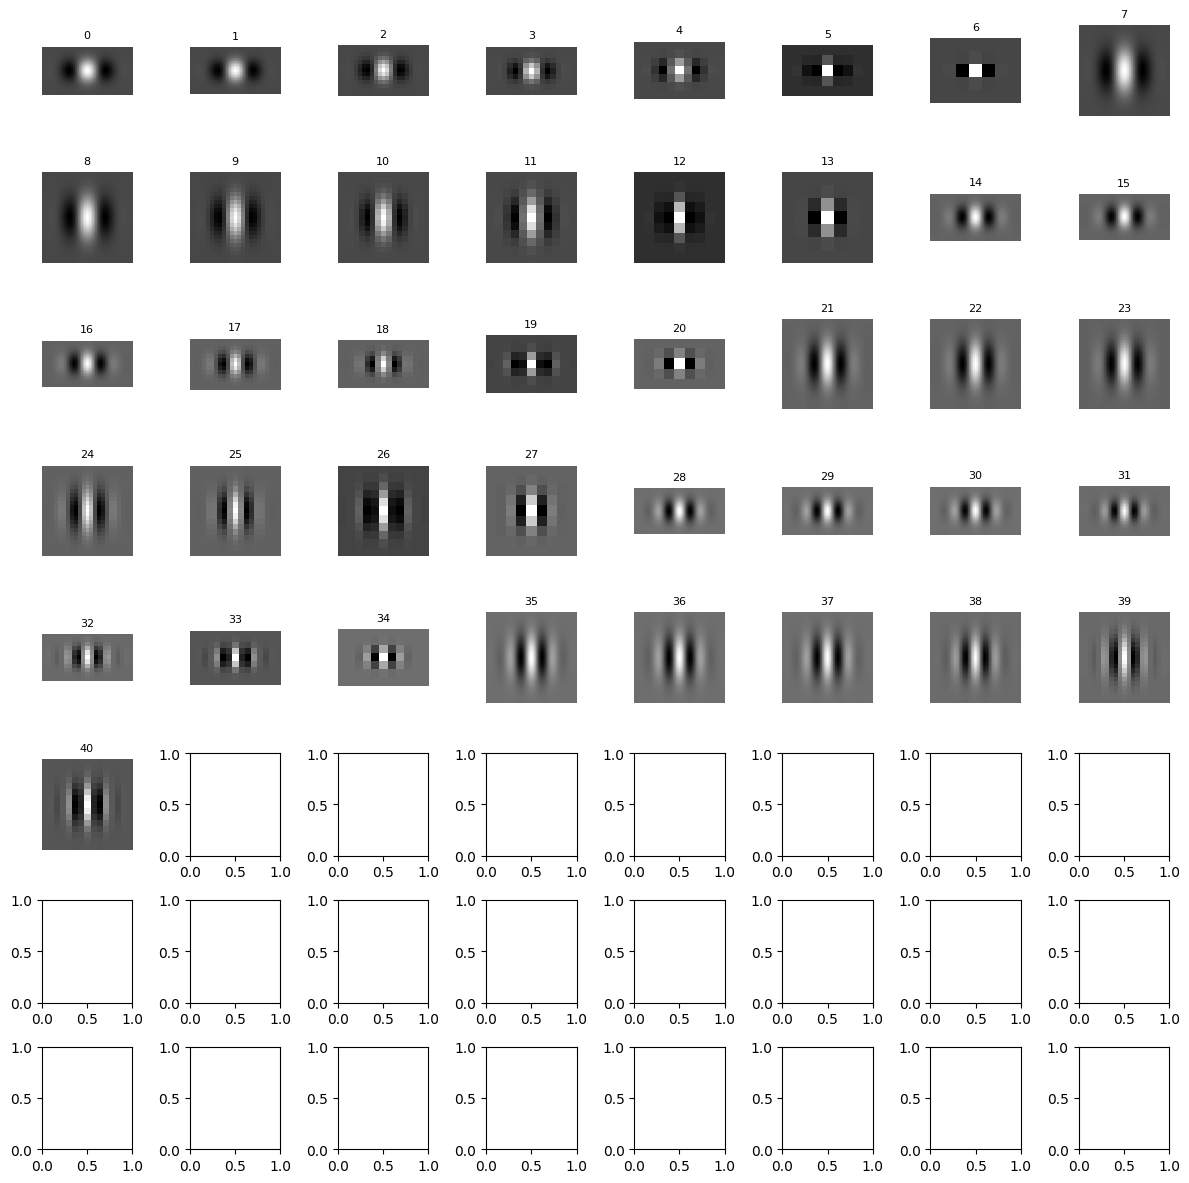

In [52]:
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()

for i in range(41):
    filt = gabor_filters[i][0] if isinstance(gabor_filters[i], list) else gabor_filters[i]
    ax = axes[i]
    ax.imshow(filt, cmap="gray")
    ax.set_title(f"{i}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

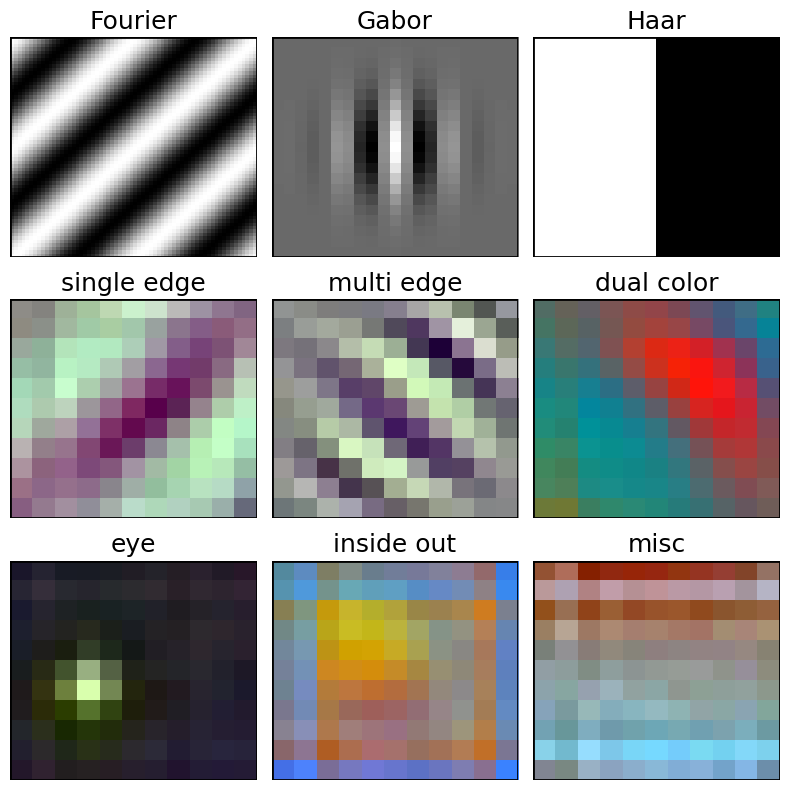

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

FONTSIZE = 18
# -----------------------
# Parameters
# -----------------------
N = 64  # resolution of the grid
x = np.linspace(0, 1, N, endpoint=False)
y = np.linspace(0, 1, N, endpoint=False)
X, Y = np.meshgrid(x, y)

# -----------------------
# Haar wavelets (2D) - 16 alternating bands
# -----------------------
haar_horizontal = np.where((np.floor(X * 2) % 2) == 0, 1, -1)
haar_vertical   = np.where((np.floor(Y * 2) % 2) == 0, 1, -1)

# -----------------------
# Fourier basis (2D)
# -----------------------
kx, ky = 2, 2
fourier_basis = np.cos(2 * np.pi * (kx * X + ky * Y))

# -----------------------
# Plot helpers
# -----------------------
def add_frame(ax, lw=2):
    ax.add_patch(
        Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,
            fill=False,
            edgecolor="black",
            linewidth=lw
        )
    )

def imshow_with_margin(ax, img, pad=0.04, **imshow_kwargs):
    """
    Draw img slightly inset inside the axes so there's a white margin
    between the image and the outer frame.
    """
    ax.imshow(
        img,
        extent=(pad, 1 - pad, pad, 1 - pad),
        transform=ax.transAxes,
        **imshow_kwargs
    )

# -----------------------
# Grid: 3x3 (top row = basis viz, bottom 2 rows = learned filters)
# -----------------------
selected = [6, 16, 2, 31, 52, 62]
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
axes = axes.flatten()

# -----------------------
# Top row (axes 0,1,2)
# -----------------------
imshow_with_margin(axes[0], fourier_basis, cmap="gray", pad=0.0)
axes[0].set_title("Fourier", fontsize=FONTSIZE)
add_frame(axes[0])
axes[0].axis("off")


filt = gabor_filters[39][0]
filt = (filt - filt.min()) / (filt.max() - filt.min())

imshow_with_margin(axes[1], filt, cmap="gray", pad=0.0)
axes[1].set_title("Gabor", fontsize=FONTSIZE)
add_frame(axes[1])
axes[1].axis("off")

imshow_with_margin(axes[2], haar_horizontal, cmap="gray", pad=0.0)
axes[2].set_title("Haar", fontsize=FONTSIZE)
add_frame(axes[2])
axes[2].axis("off")

# -----------------------
# Bottom two rows (axes 3..8): learned filters
# -----------------------
for i, idx in enumerate(selected):
    ax = axes[i + 3]
    group = next((key for key, indices in filter_groups.items() if idx in indices), "Unknown")

    filt = filters[idx]
    filt = (filt - filt.min()) / (filt.max() - filt.min())
    filt = filt.transpose(1, 2, 0)

    imshow_with_margin(ax, filt, pad=0.0)
    ax.set_title(f"{group}", fontsize=FONTSIZE)
    add_frame(ax)
    ax.axis("off")

plt.tight_layout()
plt.show()

# -----------------------
# Save
# -----------------------
if SAVE_FIGS:
    save_path = os.path.join(plots_path, "basis_toprow_plus_learned_filters_framed.jpg")
    fig.savefig(save_path, dpi=200, bbox_inches="tight")


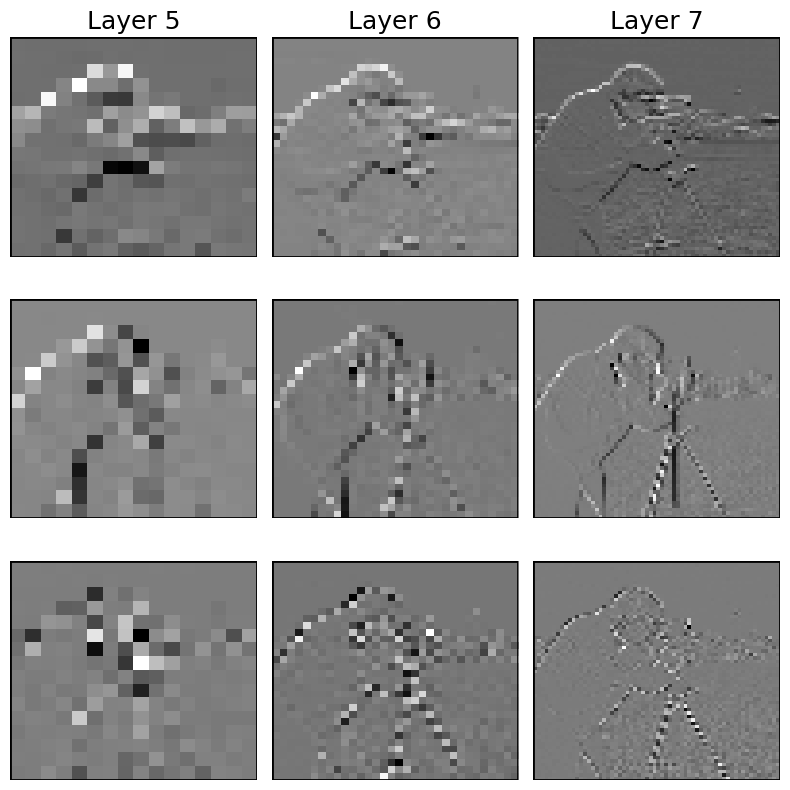

Saved: /Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/publication/paper/draft_plots/wavelet_example_3x3_framed.jpg


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pywt
import os

# -----------------------
# Settings
# -----------------------
FONTSIZE = 18
PAD = 0.00          # set to e.g. 0.04 if you want white space between image and frame
DPI = 200           # used only when saving
# SAVE_FIGS = True  # assume you already have this
# plots_path = "..."# assume you already have this

# -----------------------
# Plot helpers (same style as your template)
# -----------------------
def add_frame(ax, lw=2):
    ax.add_patch(
        Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,
            fill=False,
            edgecolor="black",
            linewidth=lw
        )
    )

def imshow_with_margin(ax, img, pad=0.00, **imshow_kwargs):
    ax.imshow(
        img,
        extent=(pad, 1 - pad, pad, 1 - pad),
        transform=ax.transAxes,
        **imshow_kwargs
    )

# -----------------------
# Make Haar wavelet decomposition images
# -----------------------
labels = ["Horizontal", "Vertical", "Diagonal"]

image = pywt.data.camera()
coeffs = pywt.wavedec2(image, "haar")
num_layers = len(coeffs) - 1  # detail layers (excluding approximation)

# Choose 3 layers so it fits a 3x3 grid (rows=orientations, cols=layers)
# This matches your prior intent of showing mid-level layers.
# Layers are 1-indexed in titles; coeffs[1:] is 0-indexed.
layer_indices = [4, 5, 6]  # -> Layer 5, 6, 7 (change if you want different ones)

# -----------------------
# Plot: 3x3 grid (like your first template)
# -----------------------
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = np.array(axes)

for col, li in enumerate(layer_indices):
    layer = coeffs[1:][li]  # (cH, cV, cD)
    for row, (arr, lab) in enumerate(zip(layer, labels)):
        ax = axes[row, col]

        imshow_with_margin(ax, arr, cmap="gray", pad=PAD)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")
        add_frame(ax, lw=2)
        ax.set_title(f" ", fontsize=FONTSIZE)

        
# Column titles
for col, li in enumerate(layer_indices):
    axes[0, col].set_title(f"Layer {li + 1}", fontsize=FONTSIZE)

plt.tight_layout()
plt.show()

# -----------------------
# Save
# -----------------------
if SAVE_FIGS:
    save_path = os.path.join(plots_path, "wavelet_example_3x3_framed.jpg")
    fig.savefig(save_path, dpi=DPI, bbox_inches="tight")
    print("Saved:", save_path)
